In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision
import datasets
from datasets import load_dataset

import nevergrad as ng

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm

import sys
sys.path.append("../")
sys.path.append("nevergrad/")

from ucimlrepo import fetch_ucirepo 
from models import CNN_Simple,All_CNN_C,VAE,LSTM,Simple_Net

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(device)

cuda:0


In [9]:
class TrainManager:
    def __init__(self, model, dataloader_train, dataloader_test, loss, device, isLSTM=False):
        self.device = device
        self.model = model.to(self.device)
        self.loss = loss.to(self.device)
        self.best_model = None
        self.dataloader_train = dataloader_train
        self.dataloader_test = dataloader_test
        self.best_score = 1e9
        self.epoch = 1
        self.n_samples = len(dataloader_train)
        self.iteration = 0
        self.test_losses = []
        self.train_losses = []
        self.accuracy = []
        self.LSTM = isLSTM
            
    def evaluate(self):
        total_correct,total_samples,loss = 0,0,0
        if not self.LSTM:
            for x , y in self.dataloader_test:
                x,y = x.to(self.device),y.to(self.device)
                y = y.flatten()
                predicted = self.model(x)
                if type(predicted) is tuple:
                    predicted = predicted[0].to(self.device)        
                loss += self.loss(predicted, y).item()

                predicted_labels = torch.argmax(predicted, axis=1)
                total_correct += torch.sum(y == predicted_labels)
                total_samples += len(predicted)
        else:
            for i, data in enumerate(self.dataloader_test):
                inputs = data.to(self.device)
                labels = inputs[:, 1:].to(self.device)
                predicted = self.model(inputs).to(self.device)
                predicted = predicted[:, :-1, :].permute(0, 2, 1)
                loss += self.loss(predicted, labels).item()
                if type(predicted) is tuple:
                    predicted = predicted[0].to(self.device)
                predicted_labels = torch.argmax(predicted, axis=1).to(self.device)
                total_correct += torch.sum(labels == predicted_labels)
                total_samples += len(predicted)

        return loss, total_correct/total_samples

    def cost_function(self, parameters):

        load_params(self.model, torch.tensor(parameters))

        if not self.LSTM:
            # Load the next batch
            inputs, labels = next(iter(self.dataloader_train))
            inputs,labels = inputs.to(self.device),labels.to(self.device)
            predicted = self.model(inputs).to(self.device)
            loss = self.loss(predicted, labels.flatten()).item()
        else:
                for i,data in enumerate(self.dataloader_train):
                    if i == self.iteration % self.n_samples:
                         inputs = data.to(self.device)
                labels = inputs[:,1:].to(self.device)
                predicted = self.model(inputs).to(self.device)
                predicted = predicted[:, :-1, :].permute(0, 2, 1)
                loss = self.loss(predicted, labels).item()

        test_loss, accuracy = self.evaluate()
        if self.best_score > test_loss :
            self.best_score = test_loss
            self.best_model = copy.deepcopy(self.model)

        print(f'epoch {self.epoch}; test loss function : {test_loss}, accuracy: {accuracy:.2f} best score : {self.best_score}')

        self.test_losses.append(test_loss)
        self.train_losses.append(loss)
        self.accuracy.append(accuracy)
        
        self.iteration += 1
        if self.iteration % self.n_samples == 0: 
            self.epoch += 1

        return loss

In [10]:
class VAE_loss(torch.nn.Module):
    def __init__(self):
        super(VAE_loss, self).__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()
    def forward(self, preds, labels):
        x, mean, logvar = preds
        reproduction_loss = self.loss_fn(x, labels)
        return reproduction_loss

In [11]:
def load_params(model, param_tensor):
    current_index = 0
    for param in model.parameters():
        param_length = param.numel()
        #print(param_length, param.size())
        param.data = param_tensor[current_index:current_index + param_length].reshape(param.size()).to(device)
        current_index += param_length
    #model.flatten_parameters()

P0 : wine (small model)

In [25]:
class create_dataset(Dataset):
    def __init__(self, data, data_classes):
        self.data = data
        self.data_classes = data_classes
        
    def __getitem__(self, index):
        x = torch.from_numpy(self.data.iloc[index][:-1].to_numpy())
        
        label = self.data.iloc[index][-1:].to_numpy()[0]
        y = np.where(data_classes == label)[0]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [26]:
wine_quality = fetch_ucirepo(id=186) 
  # data (as pandas dataframes) 
x = wine_quality.data.features 
y = wine_quality.data.targets
data = pd.concat([x, y], axis=1)
data_classes = np.sort(data["quality"].unique())

data_train, data_validation = train_test_split(data, random_state=104, test_size=0.25, shuffle=True)

scaler = StandardScaler()
columns_to_normalize = data_train.columns[data_train.columns != "quality"].tolist()
data_train[columns_to_normalize] = scaler.fit_transform(data_train[columns_to_normalize])
data_validation[columns_to_normalize] = scaler.transform(data_validation[columns_to_normalize])

dataset_train = create_dataset(data_train,data_classes)
dataset_validation = create_dataset(data_validation,data_classes)
training_loader = DataLoader(dataset_train,batch_size=len(dataset_train)//1,shuffle=True)
validation_loader = DataLoader(dataset_validation,batch_size=len(dataset_validation)//1,shuffle=False)

In [52]:
model = Simple_Net(len(data_classes)).to(device)
# loss_weights = compute_loss_weights(data_train["quality"], data_classes)
loss = nn.CrossEntropyLoss()

epochs = 5
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
#optimizer.a = 1e1*2
print(f'{epochs} epochs; {nb_batch} batchs')

5 epochs; 1 batchs


In [53]:
learned_param = optimizer.minimize(fitness)

epoch 1; test loss function : 1.936765355751057, accuracy: 0.24 best score : 1.936765355751057
epoch 2; test loss function : 1.873350005707051, accuracy: 0.29 best score : 1.873350005707051
epoch 3; test loss function : 2.0158272769593704, accuracy: 0.15 best score : 1.873350005707051
epoch 4; test loss function : 1.9782274169181815, accuracy: 0.19 best score : 1.873350005707051
epoch 5; test loss function : 2.0600061282949125, accuracy: 0.11 best score : 1.873350005707051


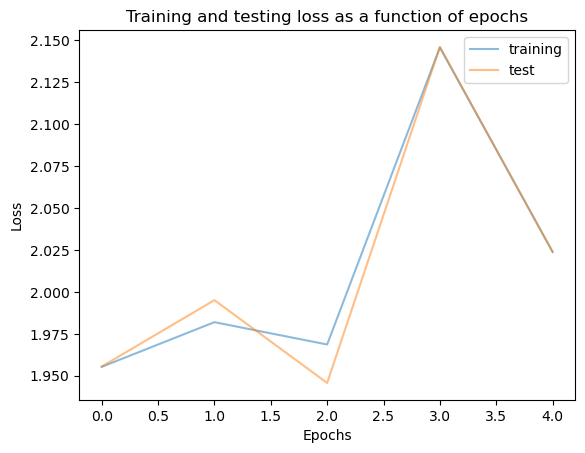

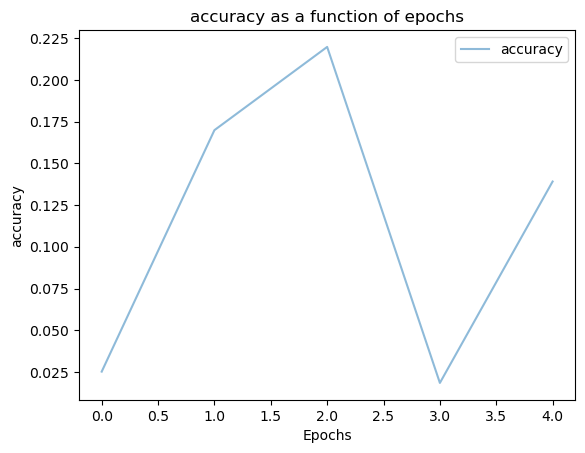

In [10]:
plt.plot(trainer.train_losses, label="training", alpha=0.5)
plt.plot(trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.plot(trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

P1 : simple CNN for classification of Fashion MNIST

In [54]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])
training_set = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//1, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//1, shuffle=False)

In [55]:
model = CNN_Simple().to(device)
torch.save(model.state_dict(), 'models/CNN_Simple.pt')
loss = nn.CrossEntropyLoss()

restart here to test another optimizer

In [56]:
model.load_state_dict(torch.load('models/CNN_Simple.pt'))

epochs = 2
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
#optimizer.a = 1e1*2
print(f'{epochs} epochs; {nb_batch} batchs')

2 epochs; 1 batchs


In [57]:
learned_param = optimizer.minimize(fitness)

epoch 1; test loss function : 2.306903323871093, accuracy: 0.10 best score : 2.306903323871093
epoch 2; test loss function : 139360.13653357534, accuracy: 0.14 best score : 2.306903323871093


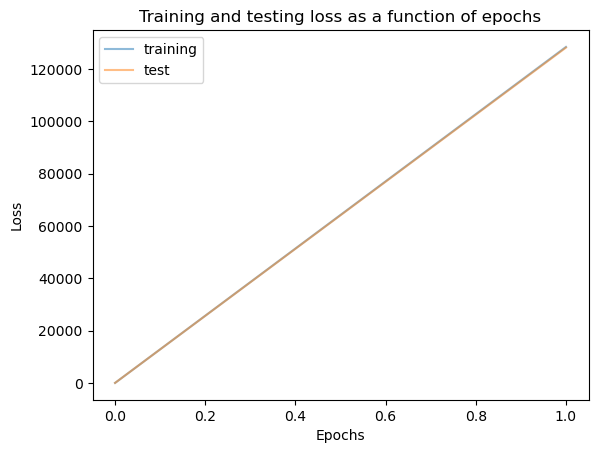

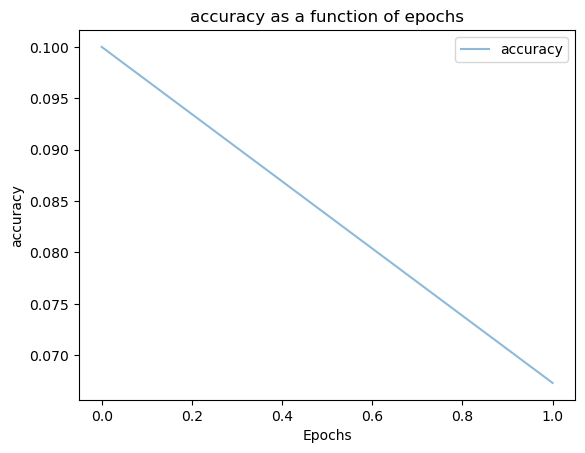

In [15]:
plt.plot(trainer.train_losses, label="training", alpha=0.5)
plt.plot(trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.plot(trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [128]:
torch.save(torch.tensor(loss), 'results/NGOptloss_P1.pt')
torch.save(torch.tensor(accuracy), 'results/NGOptaccuracy_P1.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne

P2: VAE for generation on MNIST

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double())])
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//100, shuffle=False)

In [8]:
model = VAE(device='cpu').to(device)
torch.save(model.state_dict(), 'models/VAE.pt')

In [9]:
loss = VAE_loss()

restart here for different optimizer (NGOpt and SPSA)

In [10]:
model.load_state_dict(torch.load('models/VAE.pt'))

<All keys matched successfully>

In [11]:
epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
#optimizer.a = 1e1*2
print(f'{epochs} epochs; {nb_batch} batchs')

1 epochs; 100 batchs


In [12]:
learned_param = optimizer.minimize(fitness)

ValueError: too many values to unpack (expected 3)

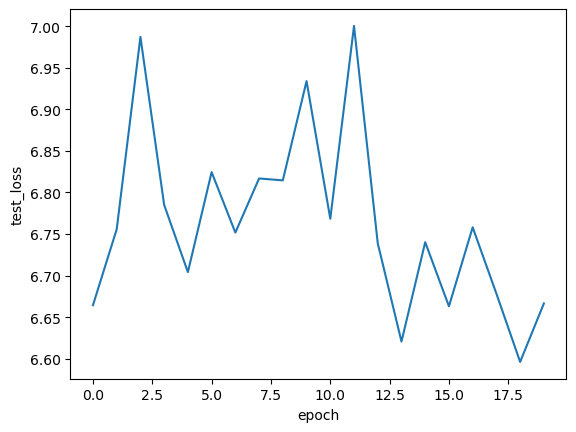

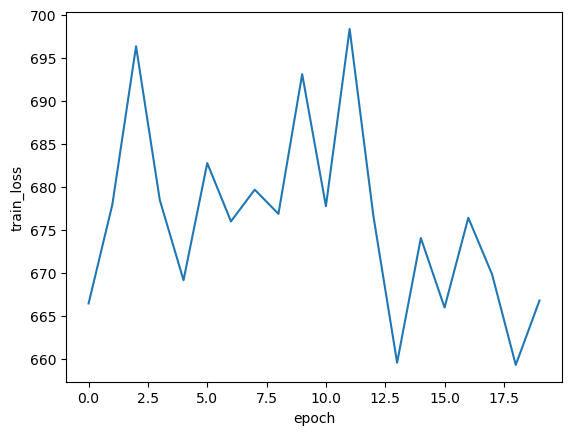

In [88]:
plt.plot(trainer.train_losses, label="training", alpha=0.5)
plt.plot(trainer.test_losses, label="test", alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("Training and testing loss as a function of epochs")
plt.legend()
plt.show()

plt.plot(trainer.accuracy, label="accuracy", alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel('Epochs')
# plt.yscale("log")
plt.title("accuracy as a function of epochs")
plt.legend()
plt.show()

In [89]:
torch.save(torch.tensor(test_loss), 'results/NGOpttestloss_P2.pt')
torch.save(torch.tensor(train_loss), 'results/NGOpttrainloss_P2.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne

P3: VAE for generation on MNIST (P2 on a different dataset)

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//100, shuffle=False)

In [13]:
model = VAE(device='cpu').to(device)
loss = VAE_loss()
# torch.save(model.state_dict(), 'models/VAE.pt')

restart here for different optimizers

In [14]:
model.load_state_dict(torch.load('models/VAE.pt'))

<All keys matched successfully>

In [15]:
epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
#optimizer.a = 1e1*2
print(f'{epochs} epochs; {nb_batch} batchs')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [81]:
learned_param = optimizer.minimize(fitness)

ValueError: too many values to unpack (expected 3)

P4: All-CNNC-C for classification on CIFAR-100

In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Lambda(lambda x: x.double()),
    transforms.Normalize((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))]
)

training_set = torchvision.datasets.CIFAR100('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR100('./data', train=False, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=len(training_set)//50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=len(validation_set)//50, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [83]:
model = All_CNN_C().to(device)
loss = torch.nn.CrossEntropyLoss()
torch.save(model.state_dict(), 'models/All_CNN_C.pt')

restart here for evaluating with different optimizers

In [84]:
model.load_state_dict(torch.load('models/All_CNN_C.pt'))

<All keys matched successfully>

In [85]:
epochs = 1
nb_batch = len(training_loader)
trainer = TrainManager(model, training_loader, validation_loader, loss, device)
fitness = trainer.cost_function

# Compute number of parameters of the model + initialize parametrization
init_params = torch.concatenate([p.data.flatten() for p in trainer.model.parameters()])
parametrization = ng.p.Array(init=init_params)
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*nb_batch, num_workers=1)
#optimizer.a = 1e1*2
print(f'{epochs} epochs; {nb_batch} batchs')

1 epochs; 50 batchs


In [86]:
learned_param = optimizer.minimize(fitness)

epoch 1; test loss function : 230.27030162775776, accuracy: 0.01 best score : 230.27030162775776


KeyboardInterrupt: 

P5: next word generation (2-layer bidirectional LSTM trained on wikitext-2)

In [6]:
from datasets import load_dataset
dataset = load_dataset("wikitext", 'wikitext-2-v1', split='train')

In [7]:
def isEnglish(sample):
    try:
        sample.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
def lowerCase(sample):
    return {"text": sample["text"].lower()}    

In [8]:
import re

dataset = dataset.filter(lambda x: 100 <= len(x['text'].split()) <= 128)
dataset = dataset.filter(lambda x: not re.match(" = .* = \n", x['text']))
dataset = dataset.filter(lambda x: isEnglish(x['text']))
dataset = dataset.map(lambda x: lowerCase(x))

In [9]:
from collections import Counter
def count_tokens(dataset):
    """Counts the frequency of each token in the dataset.
    return a dict with token as keys, frequency as values."""

    token_freq_dict = Counter(" ".join((x['text'] for x in dataset)).split())
    return token_freq_dict

def replace_rare_tokens(sample, rare_tokens, unk_token):
    text = sample["text"]
    modified_tokens = [(token if token not in rare_tokens else unk_token)
                       for token in text.split()]
    return {"text": " ".join(modified_tokens)}

def is_unknown_sequence(sample, unk_token, unk_threshold=0.1):
    sample_tokens = sample["text"].split()
    if sample_tokens.count(unk_token)/len(sample_tokens) > unk_threshold:
        return True
    else:
        return False


def build_vocabulary(dataset, min_freq=5, unk_token='<unk>'):
    """Builds a vocabulary dict for the given dataset."""
    # Get unique tokens and their frequencies.
    token_freq_dict = count_tokens(dataset)

    # Find a set of rare tokens with frequency lower than `min_freq` and replace them with `unk_token`.
    rare_tokens_set = set()
    low_freq = [x[0] for x in token_freq_dict.items() if x[1] <= min_freq]
    rare_tokens_set.update(low_freq)
    dataset = dataset.map(replace_rare_tokens, fn_kwargs={"rare_tokens": rare_tokens_set,
                                                  "unk_token": unk_token})

    # Filter out sequences with more than 15% rare tokens.
    dataset = dataset.filter(lambda x: not is_unknown_sequence(x, unk_token, unk_threshold=0.15))

    # Recompute the token frequency to get final vocabulary dict.
    token_freq_dict = count_tokens(dataset)
    return dataset, token_freq_dict


In [10]:
wikitext_dataset, token_freq_dict = build_vocabulary(dataset, min_freq=5, unk_token='<unk>')

In [11]:
class LSTMDataset(Dataset):
    def __init__(self,
                 dataset: datasets.arrow_dataset.Dataset,
                 max_seq_length: int, ):
        self.train_data = self.prepare_dataset(dataset)
        self.max_seq_length = max_seq_length + 2  # as <start> and <stop> will be added
        self.dataset_vocab = self.get_vocabulary(dataset)
        self.token2idx = {element: index for index, element in enumerate(self.dataset_vocab)}
        self.idx2token = dict(enumerate(self.dataset_vocab))
        self.pad_idx = self.token2idx["<pad>"]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        # Get a list of tokens of the given sequence. Represent each token with its index in `self.token2idx`.
        token_list = self.train_data[idx].split()
        # having a fallback to <unk> token if an unseen word is encoded.
        token_ids = [self.token2idx.get(t, self.token2idx['<unk>']) for t in token_list]

        # Add padding token to the sequence to reach the max_seq_length. 
        token_ids += [self.token2idx['<pad>']] * (self.max_seq_length - len(token_ids))

        return torch.tensor(token_ids)

    def get_vocabulary(self, dataset: datasets.arrow_dataset.Dataset):
        vocab = set()
        print("Getting dataset's vocabulary")
        for sample in tqdm(dataset):
            vocab.update(set(sample["text"].split()))
        vocab.update(set(["<start>", "<stop>", "<pad>"]))
        vocab = sorted(vocab)
        return vocab

    @staticmethod
    def prepare_dataset(target_dataset: datasets.arrow_dataset.Dataset):
        """
        Encapsulate sequences between <start> and <stop>.
        
        :param: target_dataset: the target dataset to extract samples
        return: a list of encapsulated samples.
        """
        prepared_dataset = []
        for sample in target_dataset:
            prepared_dataset.append(f"<start> {sample['text']} <stop>")
        return prepared_dataset

In [12]:
MAX_SEQ_LENGTH = 128
lstm_dataset = LSTMDataset(dataset=wikitext_dataset,
                         max_seq_length=MAX_SEQ_LENGTH)

Getting dataset's vocabulary


100%|██████████| 1158/1158 [00:00<00:00, 15017.92it/s]


In [13]:
def get_dataloader(lstm_dataset, test_ratio=0.1):
    # split train/test dataset.
    lstm_train_dataset, lstm_test_dataset = torch.utils.data.random_split(lstm_dataset, [1-test_ratio, test_ratio])
    # get pytorch DataLoader
    train_dataloader = DataLoader(lstm_train_dataset, batch_size=1158//1, shuffle=True)
    test_dataloader = DataLoader(lstm_test_dataset, batch_size=90, shuffle=False)
    return train_dataloader, test_dataloader

In [14]:
training_loader, validation_loader = get_dataloader(lstm_dataset, test_ratio=0.1)

In [15]:
vocab_size = len(lstm_dataset.token2idx)
embedding_dim = 100
hidden_dim = 100
dropout_rate = 0.15

In [16]:
model = LSTM(vocab_size=vocab_size,input_dim=embedding_dim,hidden_dim=hidden_dim,dropout_rate=dropout_rate).to(device)
loss = torch.nn.CrossEntropyLoss(ignore_index=lstm_dataset.pad_idx)
torch.save(model.state_dict(), 'models/LSTM.pt')

restart here for evaluating different optimizers

In [17]:
model.load_state_dict(torch.load('models/LSTM.pt'))

<All keys matched successfully>

In [18]:
epochs = 2
trainer = TrainManager(model,training_loader,validation_loader,loss,device,True)
fitness = trainer.cost_function
print(f'{epochs} epochs, {len(training_loader)} batchs')
# Compute number of parameters of the model + initialize parametrization
num_params = sum(p.numel() for p in model.parameters())
parametrization = ng.p.Array(shape=(num_params,))
optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=epochs*len(training_loader))


2 epochs, 1 batchs


In [19]:
learned_param = optimizer.minimize(fitness)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [24]:
loss = []
accuracy = []
for i in range(epochs*len(training_loader)):
    #if i%len(training_loader)==0:
    loss.append(trainer.output[i][0])
    accuracy.append(torch.tensor(trainer.output[i][1]*100))

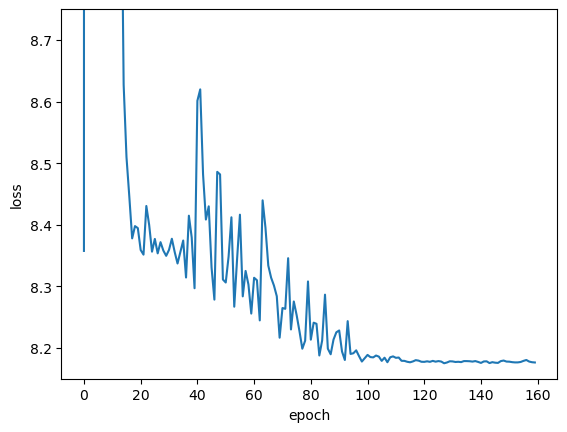

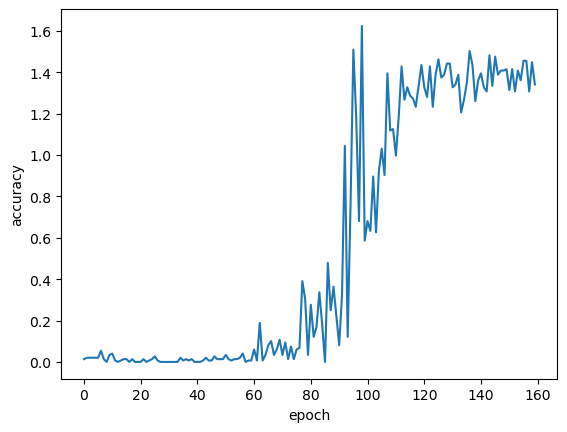

In [29]:
loss = []
accuracy = []
for i in range(epochs*len(training_loader)):
    #if i%len(training_loader)==0:
    loss.append(trainer.output[i][0])
    accuracy.append(torch.tensor(trainer.output[i][1]*100))
    
plt.plot([i for i in range(len(loss))],loss)
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.yscale('log')
plt.ylim([8.15,8.75])
plt.show()

plt.plot([i for i in range(len(accuracy))],accuracy)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [30]:
torch.save(torch.tensor(loss), 'results/NGOptloss_P5V2.pt')
torch.save(torch.tensor(accuracy), 'results/NGOptaccuracy_P5V2.pt')
optimizer._select_optimizer_cls()

MetaModelOnePlusOne

In [42]:
#loss    loss from run 2
reading = torch.load('results/NGOptloss_P5.pt')
